In [4]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx



In [ ]:
df = pd.read_excel("C:\\Users\\Rog\\Downloads\\Online_Retail.xlsx")    # Import data Online_Retail
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])   # Chuyển đổi InvoiceDate sang dạng Datetime
df['Month'] = df['InvoiceDate'].dt.month     # Trích cột tháng từ InvoiceDate và lưu vào cột mới có tên Month          
data = df[(df['Month'] >= 2) & (df['Month'] <= 6)]    # Lọc dữ liệu để chỉ lấy các giao dịch từ tháng 2 tới tháng 6
data["OrderValue"] = data["UnitPrice"] * data["Quantity"]     # Tính số tiền thu được từ mỗi giao dịch
display(data)    # Hiển thị dữ liệu

C:\Users\Rog\AppData\Local\Temp\ipykernel_13984\2300011576.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["OrderValue"] = data["UnitPrice"] * data["Quantity"]


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,OrderValue
77628,542776,21671,RED SPOT CERAMIC DRAWER KNOB,48,2011-02-01 08:23:00,1.25,15240.0,United Kingdom,2,60.00
77629,542776,21668,RED STRIPE CERAMIC DRAWER KNOB,12,2011-02-01 08:23:00,1.25,15240.0,United Kingdom,2,15.00
77630,542776,21670,BLUE SPOT CERAMIC DRAWER KNOB,12,2011-02-01 08:23:00,1.25,15240.0,United Kingdom,2,15.00
77631,542776,17013D,ORIGAMI ROSE INCENSE IN TUBE,96,2011-02-01 08:23:00,0.42,15240.0,United Kingdom,2,40.32
77632,542776,17096,ASSORTED LAQUERED INCENSE HOLDERS,48,2011-02-01 08:23:00,0.21,15240.0,United Kingdom,2,10.08
...,...,...,...,...,...,...,...,...,...,...
245898,558637,22032,BOTANICAL LILY GREETING CARD,12,2011-06-30 20:08:00,0.42,17891.0,United Kingdom,6,5.04
245899,558637,22028,PENNY FARTHING BIRTHDAY CARD,12,2011-06-30 20:08:00,0.42,17891.0,United Kingdom,6,5.04
245900,558637,22033,BOTANICAL ROSE GREETING CARD,12,2011-06-30 20:08:00,0.42,17891.0,United Kingdom,6,5.04
245901,558637,22029,SPACEBOY BIRTHDAY CARD,12,2011-06-30 20:08:00,0.42,17891.0,United Kingdom,6,5.04


In [7]:
num_items = data['Description'].nunique()   # đếm số lượng các mặt hàng
print(num_items)



3380


In [8]:
# tính tổng các mặt hàng đã bán
item_sales = (
    data.groupby('Description')  # nhóm theo tên hàng
      ['Quantity']             # chọn cột Quantity
      .sum()                   # tính tổng
      .sort_values(ascending=False)  # sắp xếp
)

top_items = item_sales.head(10) # lấy 10 mặt hàng bán nhiều nhất

other_total = item_sales.iloc[10:].sum() # tính tổng số lượng của các loại hàng còn lại

final_sales = pd.concat([top_items, pd.Series({'Other': other_total})]) # tạo series mới gồm top 10 và nhóm 'Other'
print(final_sales)


WORLD WAR 2 GLIDERS ASSTD DESIGNS       23564
JUMBO BAG RED RETROSPOT                 18104
ASSORTED COLOURS SILK FAN               15360
SMALL POPCORN HOLDER                    15292
PACK OF 72 RETROSPOT CAKE CASES         14371
PACK OF 12 LONDON TISSUES               12501
PACK OF 60 PINK PAISLEY CAKE CASES      12318
ASSORTED COLOUR BIRD ORNAMENT           11475
WHITE HANGING HEART T-LIGHT HOLDER      11445
VICTORIAN GLASS HANGING T-LIGHT         10484
Other                                 1501869
dtype: int64


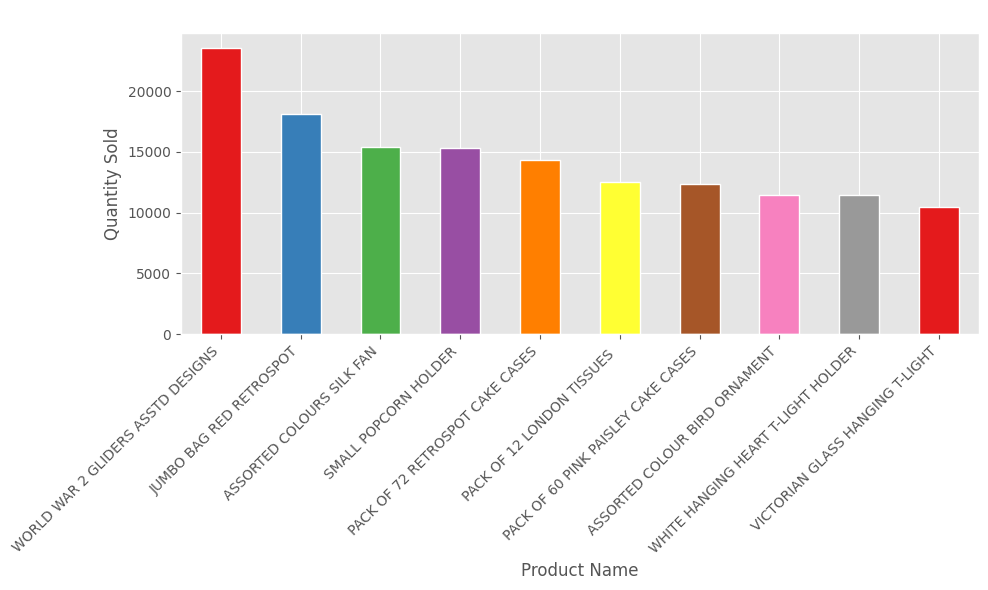

In [146]:
plt.style.use('ggplot') #chọn theme biểu đồ

colors = sns.color_palette('Set1', n_colors=10) #chọn palette màu

top_items.plot(
    kind='bar',
    figsize=(10, 6),  
    color=colors,
    edgecolor='white',
    linewidth=1
)
plt.title('Sales Volume of Top 10 Products')
plt.xlabel('Product Name')
plt.ylabel('Quantity Sold')
plt.xticks(rotation=45, ha='right')  # Xoay nhãn trục X cho dễ đọc
plt.tight_layout()  # Điều chỉnh layout
plt.show()

In [9]:
# Bỏ các đơn hàng bị hủy (InvoiceNo bắt đầu bằng 'C')
data = data[data['InvoiceNo'].notna() & ~data['InvoiceNo'].astype(str).str.startswith('C')]

# Gộp các mã sản phẩm (StockCode) theo đơn hàng
stockcode_joined = (
    data.groupby('InvoiceNo')['StockCode']
    .apply(lambda x: ', '.join(x.astype(str)))
    .reset_index(name='StockCodes')
)

# Gộp các mô tả sản phẩm (Description) theo đơn hàng
description_joined = (
    data.groupby('InvoiceNo')['Description']
    .apply(lambda x: ', '.join(x.astype(str)))
    .reset_index(name='Descriptions')
)

# Bắt đầu từ bảng invoice_summary lúc trước
invoice_summary = data[['InvoiceNo', 'InvoiceDate', 'CustomerID', 'Country', 'Month']].drop_duplicates(subset='InvoiceNo')

# Tổng giá trị hóa đơn
invoice_total = data.groupby('InvoiceNo')['OrderValue'].sum().reset_index(name='TotalOrderValue')

# Số lượng sản phẩm trong mỗi hóa đơn
item_counts = data.groupby('InvoiceNo').size().reset_index(name='ItemCount')

# Gộp tất cả lại
invoice_summary = (
    invoice_summary
    .merge(invoice_total, on='InvoiceNo', how='left')
    .merge(item_counts, on='InvoiceNo', how='left')
    .merge(stockcode_joined, on='InvoiceNo', how='left')
    .merge(description_joined, on='InvoiceNo', how='left')
)

# Sắp xếp theo thời gian (tăng dần)
invoice_summary = (
    invoice_summary
    .sort_values(by='InvoiceDate', ascending=True)
    .reset_index(drop=True)
)

# Xem kết quả
display(invoice_summary.head(20))






,InvoiceNo,InvoiceDate,CustomerID,Country,Month,TotalOrderValue,ItemCount,StockCodes,Descriptions
0,542776,2011-02-01 08:23:00,15240.0,United Kingdom,2,312.90,14,"21671, 21668, 21670, 17013D, 17096, 22469, 220...","RED SPOT CERAMIC DRAWER KNOB, RED STRIPE CERAM..."
1,542777,2011-02-01 08:31:00,14911.0,EIRE,2,797.77,45,"22374, 22371, 20654, 20658, 85039A, 85040A, 48...","AIRLINE BAG VINTAGE JET SET RED, AIRLINE BAG V..."
2,542778,2011-02-01 09:01:00,14496.0,United Kingdom,2,234.47,14,"21471, 22771, 21672, 84879, 22139, 21485, 2283...","STRAWBERRY RAFFIA FOOD COVER, CLEAR DRAWER KNO..."
3,542779,2011-02-01 09:36:00,17147.0,United Kingdom,2,409.50,18,"21121, 21122, 21124, 22858, 22859, 22860, 2286...","SET/10 RED POLKADOT PARTY CANDLES, SET/10 PINK..."
4,542780,2011-02-01 09:38:00,17675.0,United Kingdom,2,698.60,22,"82583, 85150, 85099B, 21931, 20713, 21929, 221...","HOT BATHS METAL SIGN, LADIES & GENTLEMEN METAL..."
5,542782,2011-02-01 10:00:00,12712.0,Germany,2,314.15,11,"20702, 22173, 22320, 22171, 22168, 82494L, 227...","PINK PADDED MOBILE, METAL 4 HOOK HANGER FRENCH..."
6,542783,2011-02-01 10:02:00,NaN,United Kingdom,2,0.00,1,21690,nan
7,542784,2011-02-01 10:04:00,NaN,United Kingdom,2,0.00,1,84795C,nan
8,542785,2011-02-01 10:14:00,13881.0,United Kingdom,2,1025.34,13,"48194, 48188, 22149, 22150, 21922, 84795B, 840...","DOORMAT HEARTS, DOORMAT WELCOME PUPPIES, FELTC..."
9,542786,2011-02-01 10:15:00,17314.0,United Kingdom,2,362.40,21,"22970, 22616, 22902, 22134, 22131, 22931, 2293...","LONDON BUS COFFEE MUG, PACK OF 12 LONDON TISSU..."


In [11]:
print(invoice_summary['TotalOrderValue'].describe()) #bảng summary giống trong R


count     7874.000000
mean       420.543027
std        981.230734
min          0.000000
25%        109.595000
50%        258.150000
75%        447.580000
max      38970.000000
Name: TotalOrderValue, dtype: float64


In [12]:
# Đếm số lần mỗi CustomerID xuất hiện
customer_counts = (
    invoice_summary['CustomerID']
    .value_counts()
    .reset_index(name='InvoiceCount')
    .rename(columns={'index': 'CustomerID'})
)

# Xem kết quả
display(customer_counts.head(10))
print(customer_counts['InvoiceCount'].describe()) #bảng summary giống trong R


,CustomerID,InvoiceCount
0,12748.0,63
1,14911.0,59
2,14606.0,41
3,17841.0,41
4,13089.0,39
5,12971.0,34
6,15311.0,30
7,13798.0,29
8,14646.0,26
9,16029.0,24


count    2551.000000
mean        2.515092
std         3.456121
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        63.000000
Name: InvoiceCount, dtype: float64


In [13]:
display(data.head(20))

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,OrderValue
77628,542776,21671,RED SPOT CERAMIC DRAWER KNOB,48,2011-02-01 08:23:00,1.25,15240.0,United Kingdom,2,60.00
77629,542776,21668,RED STRIPE CERAMIC DRAWER KNOB,12,2011-02-01 08:23:00,1.25,15240.0,United Kingdom,2,15.00
77630,542776,21670,BLUE SPOT CERAMIC DRAWER KNOB,12,2011-02-01 08:23:00,1.25,15240.0,United Kingdom,2,15.00
77631,542776,17013D,ORIGAMI ROSE INCENSE IN TUBE,96,2011-02-01 08:23:00,0.42,15240.0,United Kingdom,2,40.32
77632,542776,17096,ASSORTED LAQUERED INCENSE HOLDERS,48,2011-02-01 08:23:00,0.21,15240.0,United Kingdom,2,10.08
77633,542776,22469,HEART OF WICKER SMALL,12,2011-02-01 08:23:00,1.65,15240.0,United Kingdom,2,19.80
77634,542776,22077,6 RIBBONS RUSTIC CHARM,12,2011-02-01 08:23:00,1.65,15240.0,United Kingdom,2,19.80
77635,542776,79321,CHILLI LIGHTS,4,2011-02-01 08:23:00,4.95,15240.0,United Kingdom,2,19.80
77636,542776,21843,RED RETROSPOT CAKE STAND,1,2011-02-01 08:23:00,10.95,15240.0,United Kingdom,2,10.95
77637,542776,22835,HOT WATER BOTTLE I AM SO POORLY,4,2011-02-01 08:23:00,4.65,15240.0,United Kingdom,2,18.60


In [14]:
# tạo ma trận khách hàng và sản phẩm
user_product_matrix = (
    data.pivot_table(
        index='CustomerID', 
        columns='StockCode', 
        values='Quantity', 
        aggfunc='sum', 
        fill_value=0
    )
)
display(user_product_matrix)


StockCode,10002,10080,10120,10125,10133,10135,11001,15030,15034,15036,...,90214N,90214P,90214R,90214V,90214Y,BANK CHARGES,C2,M,PADS,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12348.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12350.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12352.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,2
12353.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18273.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18280.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18281.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# Tính ma trận tương đồng
user_similarity = pd.DataFrame(
    cosine_similarity(user_product_matrix),
    index=user_product_matrix.index,
    columns=user_product_matrix.index
)
display(user_similarity)

CustomerID,12347.0,12348.0,12350.0,12352.0,12353.0,12354.0,12355.0,12356.0,12359.0,12360.0,...,18257.0,18260.0,18263.0,18270.0,18272.0,18273.0,18280.0,18281.0,18283.0,18287.0
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347.0,1.000000,0.463464,0.000000,0.000534,0.0,0.005835,0.766668,0.001233,0.027769,0.068097,...,0.000000,0.001799,0.012807,0.0,0.000000,0.0,0.012228,0.000000,0.007331,0.181030
12348.0,0.463464,1.000000,0.000135,0.000209,0.0,0.000000,0.684126,0.000000,0.000000,0.000370,...,0.000000,0.000000,0.125129,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.222853
12350.0,0.000000,0.000135,1.000000,0.000597,0.0,0.000000,0.000000,0.000000,0.000000,0.077273,...,0.000000,0.000000,0.000000,0.0,0.035348,0.0,0.000000,0.000000,0.032308,0.000000
12352.0,0.000534,0.000209,0.000597,1.000000,0.0,0.029779,0.000775,0.001598,0.015086,0.001635,...,0.000000,0.000466,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.018709,0.035199
12353.0,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.006211,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18273.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.000000,0.000000,0.000000
18280.0,0.012228,0.000000,0.000000,0.000000,0.0,0.002707,0.000000,0.000000,0.012279,0.000000,...,0.000000,0.002003,0.000000,0.0,0.000000,0.0,1.000000,0.098363,0.000000,0.000000
18281.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000435,0.000000,0.000000,0.000000,0.006763,...,0.106475,0.000000,0.000000,0.0,0.000000,0.0,0.098363,1.000000,0.158902,0.000000


In [16]:
# Lấy bảng StockCode và Description, bỏ trùng
product_lookup = data[['StockCode', 'Description']].drop_duplicates()


### User-based Filtering

In [17]:
insert_user_id_here = 12347

# gọi hàm
def recommend_products(
        user_id,                 # ID của người dùng cần gợi ý
        user_product_matrix,     # Ma trận: hàng là user, cột là sản phẩm, giá trị là số lượng mua
        user_similarity,         # Ma trận độ tương đồng giữa các user (dạng cosine)
        product_lookup,          # Bảng tra mã sản phẩm và tên sản phẩm (StockCode ↔ Description)
        top_n=10):               # Số lượng sản phẩm gợi ý (mặc định là 10)

    # Nếu user không có trong dữ liệu, trả về DataFrame rỗng
    if user_id not in user_product_matrix.index:
        return pd.DataFrame(columns=['StockCode', 'Description', 'Score'])

    # Tính độ tương đồng giữa user này và các user khác
    similar_users = (
        user_similarity[user_id]
        .drop(user_id)                  # Bỏ chính user đó ra khỏi danh sách
        .sort_values(ascending=False)  # Sắp xếp giảm dần theo độ tương đồng
    )

    # Lấy ra 5 user tương đồng nhất
    top_users = similar_users.head(5).index

    # Trung bình số lượng sản phẩm mà các top_users đã mua
    recommendations = (
        user_product_matrix
        .loc[top_users]                # Lấy dòng của top_users
        .mean()                        # Trung bình theo cột (sản phẩm)
        .sort_values(ascending=False) # Sắp xếp sản phẩm theo mức độ được mua nhiều nhất
    )

    # Lấy các sản phẩm mà user đã mua
    already_bought = user_product_matrix.loc[user_id]

    # Loại bỏ các sản phẩm user đã mua rồi
    recommendations = recommendations[already_bought == 0]

    # Chuyển từ Series sang DataFrame để hiển thị
    top_recs = (
        recommendations
        .head(top_n)                         # Lấy top N sản phẩm
        .to_frame(name='Score')             # Chuyển thành DataFrame và đặt tên cột là 'Score'
        .reset_index()                      # Chuyển StockCode từ index thành cột
    )

    # Đảm bảo cột tên là 'StockCode' (phòng trường hợp bị rename sai)
    top_recs = top_recs.rename(columns={'StockCode': 'StockCode'})

    # Nối thêm tên sản phẩm từ bảng product_lookup (StockCode ↔ Description)
    top_recs = top_recs.merge(
        product_lookup,
        on='StockCode',
        how='left'                          # Giữ nguyên danh sách sản phẩm gợi ý, nối tên nếu có
    )

    # Trả kết quả: gồm StockCode, tên sản phẩm, và điểm gợi ý (Score)
    return top_recs


# Gọi hàm để gợi ý sản phẩm cho user có ID là insert_user_id_here, lấy top 10 sản phẩm
top_5 = recommend_products(
    user_id=insert_user_id_here,
    user_product_matrix=user_product_matrix,
    user_similarity=user_similarity,
    product_lookup=product_lookup,
    top_n=5
)

# Hiển thị kết quả gợi ý

display(top_5)






,StockCode,Score,Description
0,23077,16.0,DOUGHNUT LIP GLOSS
1,22197,7.2,SMALL POPCORN HOLDER
2,22197,7.2,POPCORN HOLDER
3,22693,4.8,GROW A FLYTRAP OR SUNFLOWER IN TIN
4,22754,2.6,SMALL RED BABUSHKA NOTEBOOK
5,22149,2.6,FELTCRAFT 6 FLOWER FRIENDS


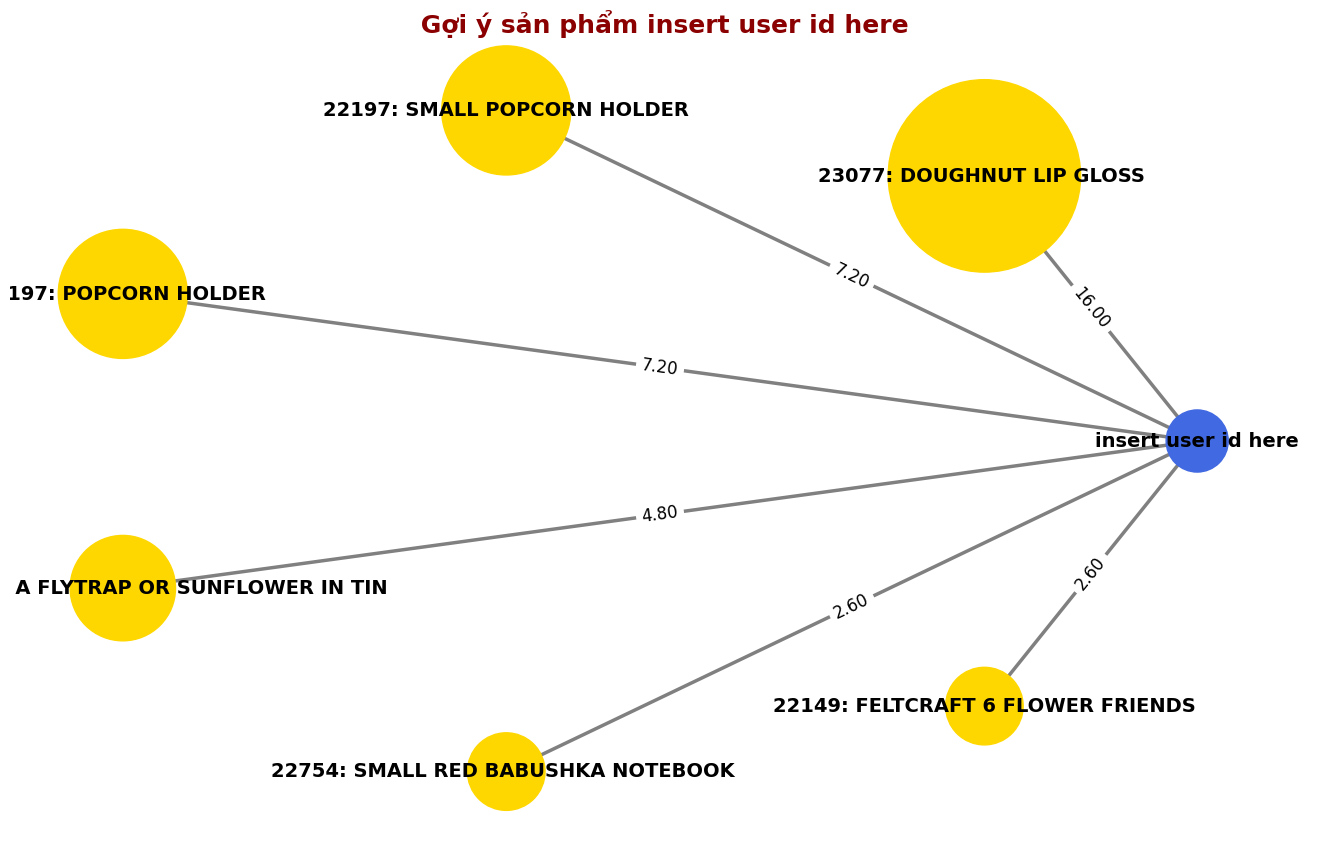

In [37]:
def draw_user_product_network(top_5, user_id='insert user id here'):
    G = nx.Graph()

    # Thêm node người dùng
    G.add_node(user_id, # ID người dùng
               label='user', # Phân loại node
                 color='royalblue', # Màu sắc node người dùng
                   size=2000)

    # Thêm node sản phẩm
    for _, row in top_5.iterrows(): # lặp qua từng sản phẩm được gợi ý
        product_node = f"{row['StockCode']}: {row['Description']}" # # Tạo tên node sản phẩm với mã + tên sản phẩm
        G.add_node(product_node, label='product', color='gold', size=row['Score'] * 1200)  # Thêm node sản phẩm vào đồ thị
        G.add_edge(user_id, product_node, weight=row['Score']) # Thêm cạnh nối người dùng với sản phẩm, mang theo điểm score

    # Lấy danh sách màu sắc & kích thước
    colors = [G.nodes[n]['color'] for n in G.nodes()]
    sizes = [G.nodes[n]['size'] for n in G.nodes()]

    # **Đặt kích thước cạnh cố định**
    fixed_edge_width = 2.5  

    # Sử dụng bố cục tròn
    pos = nx.circular_layout(G)

    # Vẽ biểu đồ với kích thước cạnh đồng đều
    plt.figure(figsize=(13, 8))
    nx.draw(G, pos, with_labels=True, node_color=colors, node_size=sizes,
            edge_color='gray', width=fixed_edge_width, font_size=14, font_weight='bold')

    # Thêm nhãn cạnh
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black', font_size=12)

    # Tiêu đề
    plt.title(f" Gợi ý sản phẩm {user_id}", fontsize=18, fontweight='bold', color="darkred")
    plt.axis('off')
    plt.show()

draw_user_product_network(top_5)

### Item-based Filtering

In [44]:
# Tạo bảng pivot: Các sản phẩm theo từng khách hàng
product_pivot = data.pivot_table(index='CustomerID', columns='StockCode', values='Quantity', aggfunc='sum', fill_value=0)

# Tính độ tương đồng giữa các sản phẩm
product_similarity = cosine_similarity(product_pivot.T)

# Chuyển thành DataFrame để dễ dàng truy vấn
product_sim_df = pd.DataFrame(product_similarity, index=product_pivot.columns, columns=product_pivot.columns)

# Kiểm tra ma trận tương đồng
display(product_sim_df.head())

def recommend_similar_products(stock_code, top_n=5):
    """
    Hàm gợi ý sản phẩm dựa vào độ tương đồng.
    
    Tham số:
    - stock_code: Mã sản phẩm cần gợi ý
    - top_n: Số lượng sản phẩm muốn hiển thị
    
    Trả về:
    - DataFrame gồm danh sách sản phẩm được đề xuất
    """
    if stock_code not in product_sim_df.index:
        return f"Sản phẩm {stock_code} không tồn tại trong dữ liệu."

    # Lấy danh sách sản phẩm tương đồng
    similar_products = product_sim_df[stock_code].sort_values(ascending=False)[1:top_n+1]
    
    # Chuyển thành bảng để hiển thị
    result_df = pd.DataFrame(similar_products).reset_index()
    result_df.columns = ['StockCode', 'SimilarityScore']


StockCode,10002,10080,10120,10125,10133,10135,11001,15030,15034,15036,...,90214N,90214P,90214R,90214V,90214Y,BANK CHARGES,C2,M,PADS,POST
StockCode,,,,,,,,,,,,,,,,,,,,,
10002,1.000000,0.0,0.004659,0.792699,0.232303,0.000000,0.019677,0.000000,0.000127,0.001374,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000187,0.0,0.00000
10080,0.000000,1.0,0.000000,0.000000,0.000000,0.013950,0.000000,0.000000,0.018709,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000
10120,0.004659,0.0,1.000000,0.002497,0.000000,0.000000,0.000000,0.000000,0.003107,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000
10125,0.792699,0.0,0.002497,1.000000,0.029135,0.006085,0.000000,0.000000,0.000058,0.000078,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013244,0.0,0.00240
10133,0.232303,0.0,0.000000,0.029135,1.000000,0.040203,0.015935,0.036539,0.010538,0.000974,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008392,0.0,0.00075


### Apriori (Market Basket Analysis)

In [45]:
from mlxtend.frequent_patterns import apriori, association_rules

# Chuyển đổi dữ liệu về dạng ma trận giỏ hàng
basket = data.groupby(['InvoiceNo', 'StockCode'])['Quantity'].sum().unstack().fillna(0)

# Chuyển đổi sang dữ liệu nhị phân (1 nếu sản phẩm xuất hiện, 0 nếu không)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

# Hiển thị một phần dữ liệu
display(basket.head())

# Tìm các tập hợp sản phẩm phổ biến
frequent_itemsets = apriori(basket, min_support=0.02, use_colnames=True)

# Hiển thị danh sách sản phẩm thường được mua cùng nhau
display(frequent_itemsets.head())

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

# Hiển thị danh sách các quy tắc kết hợp
display(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())

C:\Users\Rog\AppData\Local\Temp\ipykernel_13984\2609651832.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)


StockCode,10002,10080,10120,10125,10133,10134,10135,11001,15030,15034,...,DOT,M,PADS,POST,S,gift_0001_10,gift_0001_20,gift_0001_30,gift_0001_40,gift_0001_50
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
542776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
542777,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
542778,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
542779,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
542780,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


c:\Users\Rog\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.032131,(15036)
1,0.025527,(20676)
2,0.034671,(20685)
3,0.031750,(20711)
4,0.045974,(20712)


,antecedents,consequents,support,confidence,lift
0,(85099B),(20711),0.021590,0.216561,6.820790
1,(20711),(85099B),0.021590,0.680000,6.820790
2,(20712),(21931),0.026416,0.574586,9.309233
3,(21931),(20712),0.026416,0.427984,9.309233
4,(20712),(22386),0.024257,0.527624,8.392957
